# Function Call

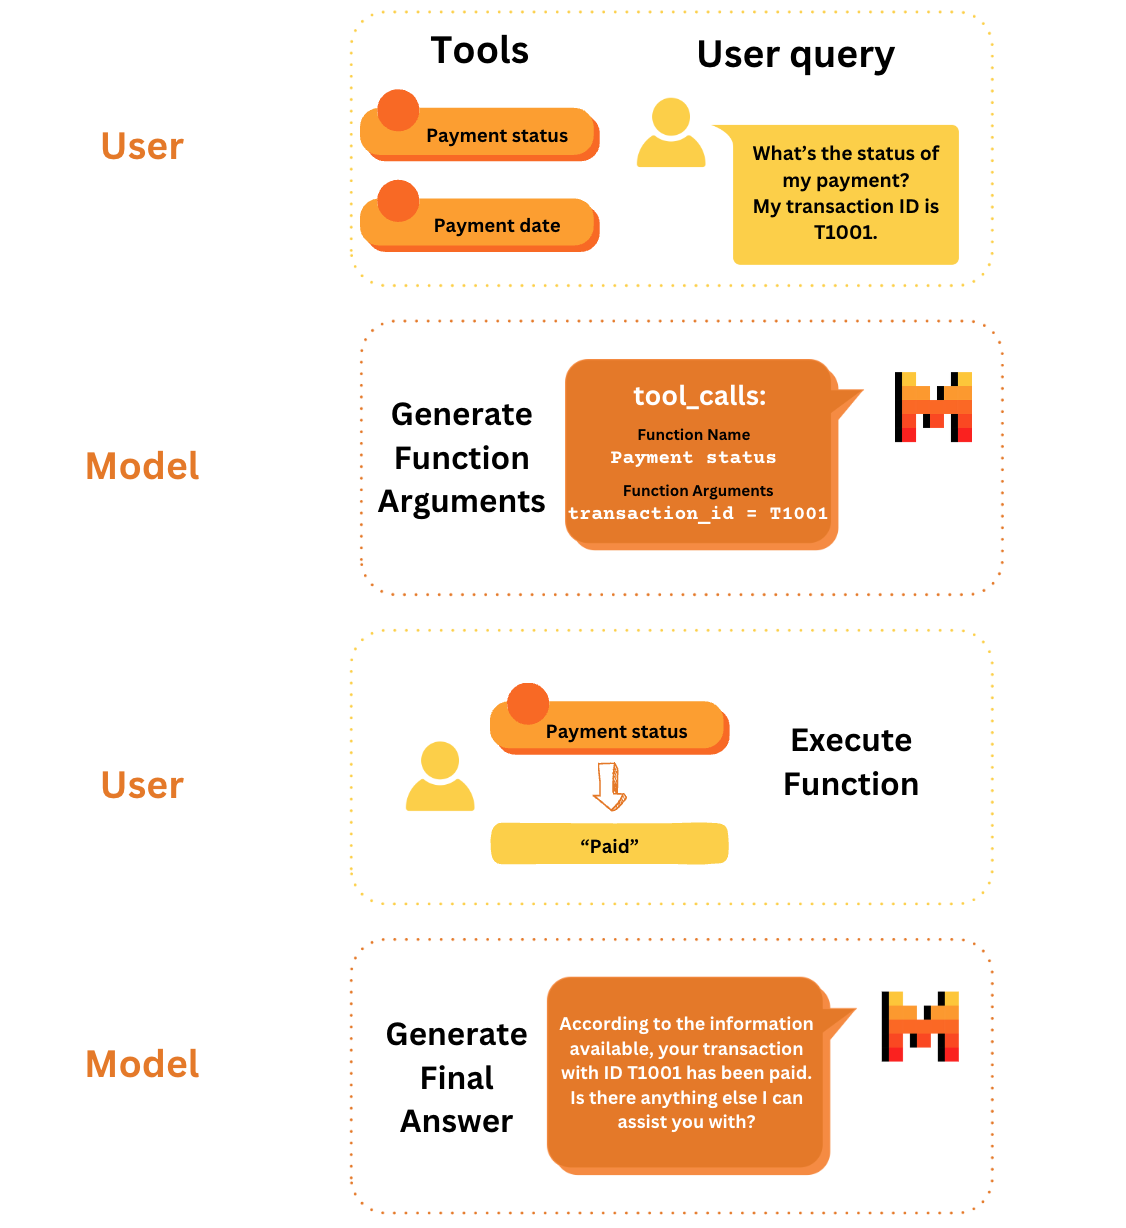# Function Calling


In [4]:
!pip install pandas mistralai

### Load API key

In [5]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("MISTRAL_KEY")

In [33]:
import os
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage

def mistral(user_message, model="mistral-small-latest", is_json=False):
    client = MistralClient(api_key=secret_value_0)

    messages = [ChatMessage(role="user", content=user_message)]

    if is_json:
        chat_response = client.chat(
            model=model, messages=messages, response_format={"type": "json_object"}
        )
    else:
        chat_response = client.chat(model=model, messages=messages)

    return chat_response.choices[0].message.content

In [7]:
import pandas as pd

In [8]:
data = {
    "transaction_id": ["T1001", "T1002", "T1003", "T1004", "T1005"],
    "customer_id": ["C001", "C002", "C003", "C002", "C001"],
    "payment_amount": [125.50, 89.99, 120.00, 54.30, 210.20],
    "payment_date": [
        "2021-10-05",
        "2021-10-06",
        "2021-10-07",
        "2021-10-05",
        "2021-10-08",
    ],
    "payment_status": ["Paid", "Unpaid", "Paid", "Paid", "Pending"],
}
df = pd.DataFrame(data)

In [9]:
df

,transaction_id,customer_id,payment_amount,payment_date,payment_status
0,T1001,C001,125.50,2021-10-05,Paid
1,T1002,C002,89.99,2021-10-06,Unpaid
2,T1003,C003,120.00,2021-10-07,Paid
3,T1004,C002,54.30,2021-10-05,Paid
4,T1005,C001,210.20,2021-10-08,Pending


#### How you might answer data questions without function calling
- Not recommended, but an example to serve as a contrast to function calling.

In [10]:
data = """
    "transaction_id": ["T1001", "T1002", "T1003", "T1004", "T1005"],
    "customer_id": ["C001", "C002", "C003", "C002", "C001"],
    "payment_amount": [125.50, 89.99, 120.00, 54.30, 210.20],
    "payment_date": [
        "2021-10-05",
        "2021-10-06",
        "2021-10-07",
        "2021-10-05",
        "2021-10-08",
    ],
    "payment_status": ["Paid", "Unpaid", "Paid", "Paid", "Pending"],
}
"""
transaction_id = "T1001"

prompt = f"""
Given the following data, what is the payment status for \
 transaction_id={transaction_id}?

data:
{data}

"""

In [11]:
response = mistral(prompt)
print(response)

The payment status for transaction_id=T1001 is "Paid".


## Step 1. User: specify tools and query

### Tools

- You can define all tools that you might want the model to call.

In [12]:
import json

In [13]:
def retrieve_payment_status(df: data, transaction_id: str) -> str:
    if transaction_id in df.transaction_id.values:
        return json.dumps(
            {"status": df[df.transaction_id == transaction_id].payment_status.item()}
        )
    return json.dumps({"error": "transaction id not found."})

In [14]:
status = retrieve_payment_status(df, transaction_id="T1001")
print(status)

{"status": "Paid"}


In [15]:
type(status)

str

In [16]:
def retrieve_payment_date(df: data, transaction_id: str) -> str:
    if transaction_id in df.transaction_id.values:
        return json.dumps(
            {"date": df[df.transaction_id == transaction_id].payment_date.item()}
        )
    return json.dumps({"error": "transaction id not found."})

In [17]:
date = retrieve_payment_date(df, transaction_id="T1002")
print(date)

{"date": "2021-10-06"}


- You can outline the function specifications with a JSON schema.

In [18]:
tool_payment_status = {
    "type": "function",
    "function": {
        "name": "retrieve_payment_status",
        "description": "Get payment status of a transaction",
        "parameters": {
            "type": "object",
            "properties": {
                "transaction_id": {
                    "type": "string",
                    "description": "The transaction id.",
                }
            },
            "required": ["transaction_id"],
        },
    },
}

In [19]:
type(tool_payment_status)

dict

In [20]:
tool_payment_date = {
    "type": "function",
    "function": {
        "name": "retrieve_payment_date",
        "description": "Get payment date of a transaction",
        "parameters": {
            "type": "object",
            "properties": {
                "transaction_id": {
                    "type": "string",
                    "description": "The transaction id.",
                }
            },
            "required": ["transaction_id"],
        },
    },
}

In [21]:
type(tool_payment_status)

dict

In [22]:
tools = [tool_payment_status, tool_payment_date]

In [23]:
type(tools)

list

In [24]:
tools

[{'type': 'function',
  'function': {'name': 'retrieve_payment_status',
   'description': 'Get payment status of a transaction',
   'parameters': {'type': 'object',
    'properties': {'transaction_id': {'type': 'string',
      'description': 'The transaction id.'}},
    'required': ['transaction_id']}}},
 {'type': 'function',
  'function': {'name': 'retrieve_payment_date',
   'description': 'Get payment date of a transaction',
   'parameters': {'type': 'object',
    'properties': {'transaction_id': {'type': 'string',
      'description': 'The transaction id.'}},
    'required': ['transaction_id']}}}]

### functools

In [25]:
import functools

In [26]:
names_to_functions = {
    "retrieve_payment_status": functools.partial(retrieve_payment_status, df=df),
    "retrieve_payment_date": functools.partial(retrieve_payment_date, df=df),
}

In [27]:
names_to_functions["retrieve_payment_status"](transaction_id="T1001")

'{"status": "Paid"}'

In [28]:
tools

[{'type': 'function',
  'function': {'name': 'retrieve_payment_status',
   'description': 'Get payment status of a transaction',
   'parameters': {'type': 'object',
    'properties': {'transaction_id': {'type': 'string',
      'description': 'The transaction id.'}},
    'required': ['transaction_id']}}},
 {'type': 'function',
  'function': {'name': 'retrieve_payment_date',
   'description': 'Get payment date of a transaction',
   'parameters': {'type': 'object',
    'properties': {'transaction_id': {'type': 'string',
      'description': 'The transaction id.'}},
    'required': ['transaction_id']}}}]

### User query

- Example: “What’s the status of my transaction?”

In [29]:
from mistralai.models.chat_completion import ChatMessage

chat_history = [
    ChatMessage(role="user", content="What's the status of my transaction?")
]

## Step 2. Model: Generate function arguments 

In [34]:
from mistralai.client import MistralClient

model = "mistral-large-latest"

client = MistralClient(api_key=secret_value_0)
response = client.chat(
    model=model, messages=chat_history, tools=tools, tool_choice="auto"
)

response

ChatCompletionResponse(id='0e3535faeb804437999f27abf25a4809', object='chat.completion', created=1714813469, model='mistral-large-latest', choices=[ChatCompletionResponseChoice(index=0, message=ChatMessage(role='assistant', content='To help you with that, I would need the transaction ID. Could you please provide it?', name=None, tool_calls=None), finish_reason=<FinishReason.stop: 'stop'>)], usage=UsageInfo(prompt_tokens=161, total_tokens=180, completion_tokens=19))

In [35]:
response.choices[0].message.content

'To help you with that, I would need the transaction ID. Could you please provide it?'

### Save the chat history

In [36]:
chat_history.append(
    ChatMessage(role="assistant", content=response.choices[0].message.content)
)
chat_history.append(ChatMessage(role="user", content="My transaction ID is T1001."))
chat_history

[ChatMessage(role='user', content="What's the status of my transaction?", name=None, tool_calls=None),
 ChatMessage(role='assistant', content='To help you with that, I would need the transaction ID. Could you please provide it?', name=None, tool_calls=None),
 ChatMessage(role='user', content='My transaction ID is T1001.', name=None, tool_calls=None)]

In [37]:
response = client.chat(
    model=model, messages=chat_history, tools=tools, tool_choice="auto"
)

In [38]:
response

ChatCompletionResponse(id='8793f02737964b53b73fd4ce55edb3e2', object='chat.completion', created=1714813481, model='mistral-large-latest', choices=[ChatCompletionResponseChoice(index=0, message=ChatMessage(role='assistant', content='', name=None, tool_calls=[ToolCall(id='2nRojwoG5', type=<ToolType.function: 'function'>, function=FunctionCall(name='retrieve_payment_status', arguments='{"transaction_id": "T1001"}'))]), finish_reason=<FinishReason.tool_calls: 'tool_calls'>)], usage=UsageInfo(prompt_tokens=193, total_tokens=223, completion_tokens=30))

In [39]:
response.choices[0].message

ChatMessage(role='assistant', content='', name=None, tool_calls=[ToolCall(id='2nRojwoG5', type=<ToolType.function: 'function'>, function=FunctionCall(name='retrieve_payment_status', arguments='{"transaction_id": "T1001"}'))])

In [40]:
chat_history.append(response.choices[0].message)

- Notice these fields:
- `name='retrieve_payment_status'`
- `arguments='{"transaction_id": "T1001"}'`

## Step 3. User: Execute function to obtain tool results

- Currently, the user is the one who will execute these functions (the model will not execute these functions on its own).

In [41]:
tool_function = response.choices[0].message.tool_calls[0].function
print(tool_function)

name='retrieve_payment_status' arguments='{"transaction_id": "T1001"}'


In [42]:
tool_function.name

'retrieve_payment_status'

In [43]:
tool_function.arguments

'{"transaction_id": "T1001"}'

- The function arguments are expected to be in a Python dictionary and not a string.
- To make this string into a dictionary, you can use `json.loads()`  

In [44]:
args = json.loads(tool_function.arguments)
print(args)

{'transaction_id': 'T1001'}


- Recall the functools dictionary that you made earlier

```Python
import functools
names_to_functions = {
    "retrieve_payment_status": 
      functools.partial(retrieve_payment_status, df=df),
    
    "retrieve_payment_date": 
      functools.partial(retrieve_payment_date, df=df),
}
```

In [45]:
function_result = names_to_functions[tool_function.name](**args)
function_result

'{"status": "Paid"}'

- The output of the function call can be saved as a chat message, with the role "tool".

In [46]:
tool_msg = ChatMessage(role="tool", name=tool_function.name, content=function_result)
chat_history.append(tool_msg)

In [47]:
chat_history

[ChatMessage(role='user', content="What's the status of my transaction?", name=None, tool_calls=None),
 ChatMessage(role='assistant', content='To help you with that, I would need the transaction ID. Could you please provide it?', name=None, tool_calls=None),
 ChatMessage(role='user', content='My transaction ID is T1001.', name=None, tool_calls=None),
 ChatMessage(role='assistant', content='', name=None, tool_calls=[ToolCall(id='2nRojwoG5', type=<ToolType.function: 'function'>, function=FunctionCall(name='retrieve_payment_status', arguments='{"transaction_id": "T1001"}'))]),
 ChatMessage(role='tool', content='{"status": "Paid"}', name='retrieve_payment_status', tool_calls=None)]

## Step 4. Model: Generate final answer
- The model can now reply to the user query, given the information provided by the "tool".

In [48]:
response = client.chat(model=model, messages=chat_history)
response.choices[0].message.content

'Your transaction with the ID T1001 has been successfully paid.'

### Try it for yourself!
- Try asking another question about the data, such as "how much did I pay my recent order?
  - You can be customer "T1002", for instance